<a href="https://colab.research.google.com/github/jjsmartin/rl-scratchpad/blob/main/Copy_of_2021_05_07_DQN_LunarLander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lunar Lander DQN

https://gymnasium.farama.org/environments/box2d/lunar_lander/

In [2]:
# !pip install -q swig
# !pip install -q gymnasium[box2d]

In [3]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import deque, namedtuple

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model

# For visualization
from gymnasium.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

2023-09-27 23:03:25.572058: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Instantiate the Environment and Agent

Initialize the environment.

In [125]:
env = gym.make('LunarLander-v2')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [4]:
def build_qnetwork(state_size, action_size):
    inputs = tf.keras.Input(shape=(state_size,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(action_size)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

### Hyperparameters

In [5]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [6]:
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
else:
    device = '/CPU:0'

### Define Agent

In [7]:
class Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Networks
        self.qnetwork_local = build_qnetwork(state_size, action_size)
        self.qnetwork_target = build_qnetwork(state_size, action_size)
        self.optimizer = Adam(learning_rate=0.001)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = np.reshape(state, [1, self.state_size])
        action_values = self.qnetwork_local.predict(state, verbose=0)

        if np.random.rand() > eps:
            return np.argmax(action_values[0])
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # TODO do this properly
        rewards = rewards.reshape(-1)
        dones = dones.reshape(-1)

        # Compute and minimize the loss
        q_targets_next = np.amax(self.qnetwork_target.predict(next_states), axis=1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        
        q_expected = self.qnetwork_local.predict(states)
        for i, action in enumerate(actions):
            q_expected[i][action] = q_targets[i]

        mse = MeanSquaredError()
        with tf.GradientTape() as tape:
            predictions = self.qnetwork_local(states, training=True)
            loss = mse(q_expected, predictions)
        grads = tape.gradient(loss, self.qnetwork_local.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.qnetwork_local.trainable_variables))

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        local_weights = local_model.get_weights()
        target_weights = target_model.get_weights()
        
        # Ensure both models have the same number of layers
        assert len(local_weights) == len(target_weights), "Local and target models have different numbers of layers"

        # Perform soft update
        for i in range(len(local_weights)):
            target_weights[i] = tau * local_weights[i] + (1 - tau) * target_weights[i]

        target_model.set_weights(target_weights)


### Define Replay Buffer

In [184]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): Dimension of each action
            buffer_size (int): Maximum size of buffer
            batch_size (int): Size of each training batch
            seed (int): Random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.vstack([e.action for e in experiences if e is not None])
        rewards = np.vstack([e.reward for e in experiences if e is not None])
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        dones = np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


### Training Process

In [185]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated # new API
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode - 100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            agent.qnetwork_local.save_weights('checkpoint.h5')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0) 
scores = dqn()


2/2 [==============================] - 0s 3ms/step


KeyboardInterrupt: 

### Plot the learning progress

NameError: name 'scores' is not defined

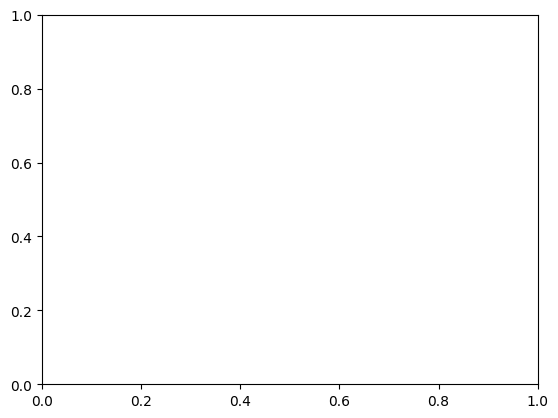

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Animate it with Video

In [17]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()

        action = agent.act(state)

        state, reward, done, _ = env.step(action)
    env.close()

In [20]:
!mkdir video

In [21]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 

In [22]:
show_video('LunarLander-v2')